In [42]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [44]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [45]:
train_loader = DataLoader(train_dataset, batch_size=256 + 192, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256 + 192, shuffle=False)

In [46]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [47]:
def calculate_entropy(weights):
    """Calculate entropy of a weight distribution."""
    flat_weights = weights.detach().cpu().numpy().flatten()
    histogram, _ = np.histogram(flat_weights, bins=50, density=True)
    histogram = histogram[histogram > 0]  # Remove zero probabilities
    return -np.sum(histogram * np.log(histogram))

def calculate_energy(weights):
    """Calculate energy as the squared sum of weights."""
    flat_weights = weights.detach().cpu().numpy().flatten()
    return np.sum(flat_weights**2)

def calculate_sparsity(tensor, epsilon=1e-3):
    """Calculate sparsity as the fraction of near-zero elements."""
    flat_tensor = tensor.detach().cpu().numpy().flatten()
    near_zero_count = np.sum(np.abs(flat_tensor) < epsilon)
    return near_zero_count / len(flat_tensor)

def calculate_gradient_entropy(gradients):
    """Calculate entropy of the gradients."""
    flat_grad = gradients.detach().cpu().numpy().flatten()
    histogram, _ = np.histogram(flat_grad, bins=50, density=True)
    histogram = histogram[histogram > 0]
    return -np.sum(histogram * np.log(histogram))

def calculate_gradient_energy(gradients):
    """Calculate energy (sum of squares) of the gradients."""
    flat_grad = gradients.detach().cpu().numpy().flatten()
    return np.sum(flat_grad**2)

def calculate_activation_entropy(activations):
    """Calculate entropy of activations."""
    flat_activations = activations.detach().cpu().numpy().flatten()
    histogram, _ = np.histogram(flat_activations, bins=50, density=True)
    histogram = histogram[histogram > 0]
    return -np.sum(histogram * np.log(histogram))


In [ ]:
def train_model_with_metrics(model, train_loader, criterion, optimizer, epochs):
    # Initialize logs
    entropy_log, energy_log = [], []
    sparsity_log, gradient_entropy_log, gradient_energy_log, activation_entropy_log = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        epoch_entropy = 0
        epoch_energy = 0
        epoch_sparsity = 0
        epoch_grad_entropy = 0
        epoch_grad_energy = 0
        epoch_act_entropy = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # **Update weights** (added step)
            optimizer.step()

            # Track metrics
            total_loss += loss.item()

            # Calculate metrics for weights, gradients, and activations
            batch_entropy, batch_energy, batch_sparsity = 0, 0, 0
            batch_grad_entropy, batch_grad_energy, batch_act_entropy = 0, 0, 0

            for name, param in model.named_parameters():
                if param.requires_grad:
                    # Weight metrics
                    batch_entropy += calculate_entropy(param)
                    batch_energy += calculate_energy(param)
                    batch_sparsity += calculate_sparsity(param)

                    # Gradient metrics
                    batch_grad_entropy += calculate_gradient_entropy(param.grad)
                    batch_grad_energy += calculate_gradient_energy(param.grad)

            # Activation metrics (from the output of the last layer)
            batch_act_entropy = calculate_activation_entropy(outputs)

            # Accumulate batch metrics
            epoch_entropy += batch_entropy
            epoch_energy += batch_energy
            epoch_sparsity += batch_sparsity
            epoch_grad_entropy += batch_grad_entropy
            epoch_grad_energy += batch_grad_energy
            epoch_act_entropy += batch_act_entropy

        # Log epoch metrics
        entropy_log.append(epoch_entropy)
        energy_log.append(epoch_energy)
        sparsity_log.append(epoch_sparsity / len(train_loader))  # Average sparsity
        gradient_entropy_log.append(epoch_grad_entropy)
        gradient_energy_log.append(epoch_grad_energy)
        activation_entropy_log.append(epoch_act_entropy / len(train_loader))  # Average activation entropy

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")
        print(f"  Entropy: {epoch_entropy:.4f}, Energy: {epoch_energy:.4f}, Sparsity: {epoch_sparsity/len(train_loader):.4f}")
        print(f"  Gradient Entropy: {epoch_grad_entropy:.4f}, Gradient Energy: {epoch_grad_energy:.4f}")
        print(f"  Activation Entropy: {epoch_act_entropy/len(train_loader):.4f}")

    return entropy_log, energy_log, sparsity_log, gradient_entropy_log, gradient_energy_log, activation_entropy_log


In [49]:
def plot_metrics_with_additional_logs(entropy_log, energy_log, sparsity_log, grad_entropy_log, grad_energy_log, act_entropy_log, epochs):
    plt.figure(figsize=(16, 10))

    # Entropy and Energy
    plt.subplot(2, 2, 1)
    plt.plot(range(epochs), entropy_log, label="Entropy")
    plt.plot(range(epochs), energy_log, label="Energy")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Entropy and Energy vs Epochs")
    plt.legend()

    # Sparsity
    plt.subplot(2, 2, 2)
    plt.plot(range(epochs), sparsity_log, label="Sparsity")
    plt.xlabel("Epochs")
    plt.ylabel("Sparsity")
    plt.title("Sparsity vs Epochs")
    plt.legend()

    # Gradient Metrics
    plt.subplot(2, 2, 3)
    plt.plot(range(epochs), grad_entropy_log, label="Gradient Entropy")
    plt.plot(range(epochs), grad_energy_log, label="Gradient Energy")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Gradient Metrics vs Epochs")
    plt.legend()

    # Activation Entropy
    plt.subplot(2, 2, 4)
    plt.plot(range(epochs), act_entropy_log, label="Activation Entropy")
    plt.xlabel("Epochs")
    plt.ylabel("Activation Entropy")
    plt.title("Activation Entropy vs Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch [1/1], Loss: 310.1964
  Entropy: -1338967.3106, Energy: 34792.8750, Sparsity: 0.1266
  Gradient Entropy: -15047953.2950, Gradient Energy: 75.0501
  Activation Entropy: -4.6346


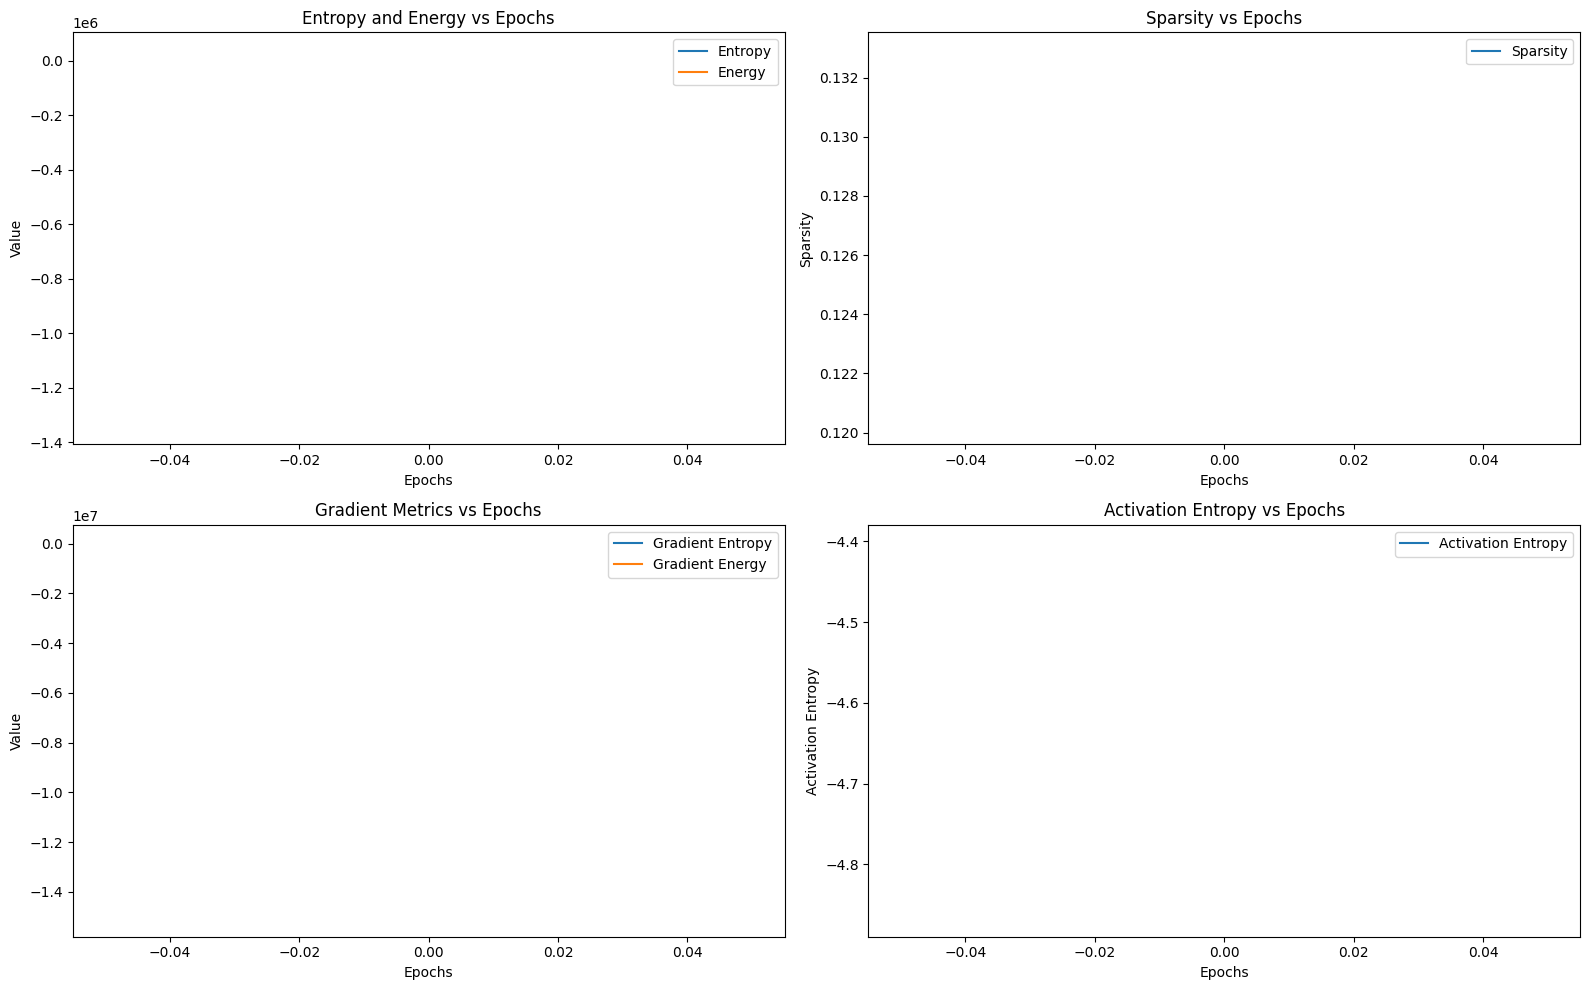

In [52]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, and Optimizer
model = MNISTNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training and Metric Analysis
epochs = 1
entropy_log, energy_log, sparsity_log, grad_entropy_log, grad_energy_log, act_entropy_log = train_model_with_metrics(
    model, train_loader, criterion, optimizer, epochs
)

# Plot all metrics
plot_metrics_with_additional_logs(entropy_log, energy_log, sparsity_log, grad_entropy_log, grad_energy_log, act_entropy_log, epochs)


In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

def evaluate_model_on_test_set(model, test_loader, device):
    """
    Evaluate the trained model on the test dataset and calculate MSE, MAE, and Accuracy.
    
    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test dataset.
        device: Device to run the predictions on ('cpu' or 'cuda').

    Returns:
        mse: Mean Squared Error.
        mae: Mean Absolute Error.
        accuracy: Classification accuracy.
    """
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Store ground truth and predictions
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return mse, mae, accuracy

# Evaluate the model
mse, mae, accuracy = evaluate_model_on_test_set(model, test_loader, device)

Mean Squared Error (MSE): 15.6451
Mean Absolute Error (MAE): 3.1643
Accuracy: 14.38%


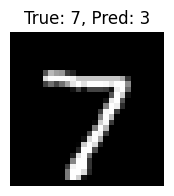

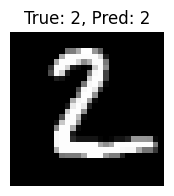

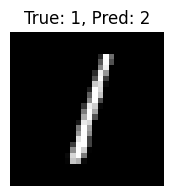

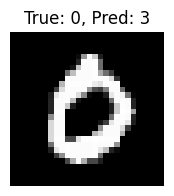

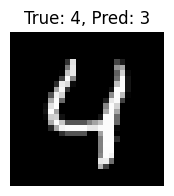

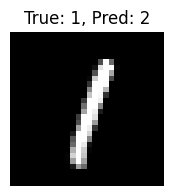

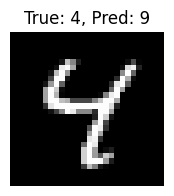

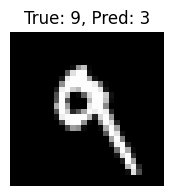

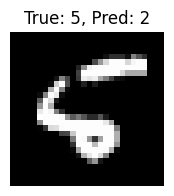

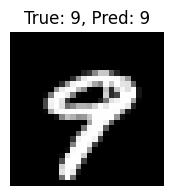

In [54]:
import matplotlib.pyplot as plt

def predict_and_visualize(model, test_loader, device, num_samples=10):
    """
    Make predictions using the trained model on the test dataset and visualize a few results.

    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test dataset.
        device: Device to run the predictions on ('cpu' or 'cuda').
        num_samples: Number of samples to visualize.
    """
    model.eval()  # Set model to evaluation mode
    samples_shown = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Visualize a few samples
            for i in range(len(images)):
                if samples_shown >= num_samples:
                    break

                image = images[i].cpu().numpy().squeeze()  # Convert tensor to NumPy
                true_label = labels[i].item()
                pred_label = predicted[i].item()

                # Plot the image with prediction and ground truth
                plt.figure(figsize=(2, 2))
                plt.imshow(image, cmap='gray')
                plt.title(f"True: {true_label}, Pred: {pred_label}")
                plt.axis('off')
                plt.show()

                samples_shown += 1
            if samples_shown >= num_samples:
                break

# Predict and visualize results
predict_and_visualize(model, test_loader, device, num_samples=10)